# Streaming in LangGraph

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o')
llm.invoke('hello')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0HR8L7nTrk6l8LEVsAZCSMQvO2u6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a7a0cd47-0459-47b4-81b0-e299649f2cdf-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langchain_groq import ChatGroq
llm_groq = ChatGroq(model = 'qwen/qwen3-32b')
llm_groq.invoke('hello')

AIMessage(content='<think>\nOkay, the user just said "hello". I need to respond appropriately. Let me start by acknowledging their greeting. Maybe add a friendly emoji to keep it warm. I should ask how I can assist them today to open the conversation. Keep it simple and welcoming. Let me make sure the tone is positive and helpful.\n</think>\n\nHello! 😊 How can I assist you today? Let me know if you have any questions or need help with something specific!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 9, 'total_tokens': 104, 'completion_time': 0.160264732, 'prompt_time': 0.006137358, 'queue_time': 0.193874208, 'total_time': 0.16640209}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7a7f7e99-91ef-44c2-89c5-77e3c04f52c1-0', usage_metadata={'input_tokens': 9, 'output_tokens': 95, 'total_tokens': 104})

# Creating nodes

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
def superbot(state: State):
    return {'messages': [llm_groq.invoke(state['messages'])]}

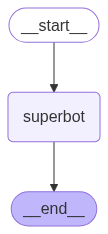

In [22]:
from IPython.display import Image, display 
graph = StateGraph(State)
graph.add_node('superbot', superbot)

## add edges
graph.add_edge(START, 'superbot')
graph.add_edge('superbot', END)

# compile graph
graph_builder = graph.compile()

# display
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [23]:
## invocation
config = {'configurable': {'thread_id':'1'}}
graph_builder.invoke({'messages': 'Hello my name is abcd and I like cricket'},config)

{'messages': [HumanMessage(content='Hello my name is abcd and I like cricket', additional_kwargs={}, response_metadata={}, id='a83a3b75-0ed9-426b-b751-c12507a4a882'),
  AIMessage(content='<think>\nOkay, the user introduced themselves as "abcd" and mentioned they like cricket. First, I need to respond in a friendly and welcoming manner. Since the name is "abcd," maybe they used a placeholder or just want to keep their name anonymous. I should acknowledge their introduction and express enthusiasm about their interest in cricket.\n\nI should ask a follow-up question to encourage them to share more about why they like cricket or how they got into it. Maybe something like, "That\'s great! What made you start following cricket, or do you play it as well?" That way, it opens the door for a more detailed conversation.\n\nI also need to make sure the tone is positive and supportive. Avoid any assumptions about why they chose "abcd" as a name. Keep the focus on their interest in cricket. Maybe m

## Streaming responses with stream()
- stream_mode = 'updates': streams the latest state of graph
- stream_mode = 'values: streams the full state of graph (all convos)

In [26]:
# create a thread
config = {'configurable': {'thread_id':'2'}}
for chunk in graph_builder.stream({'messages': 'Hello my name is abcd and I like cricket'}, config=config, stream_mode='updates'):
    print(chunk)
    


{'superbot': {'messages': [AIMessage(content="<think>\nOkay, the user introduced themselves as abcd and mentioned they like cricket. I should acknowledge their introduction and express that it's a pleasure to meet them. Since they like cricket, maybe I can ask them about their favorite team or player to keep the conversation going. I should also offer help if they need anything related to cricket or other topics. Let me check for any typos and make sure the response is friendly and engaging.\n</think>\n\nHello abcd! It's a pleasure to meet you. 🏏 I know cricket is an amazing sport—do you have a favorite team or player? I'd love to hear more about what you enjoy about it! Whether you're looking to discuss matches, strategies, or just share your passion, I'm here to chat. 😊 What would you like to explore today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 168, 'prompt_tokens': 18, 'total_tokens': 186, 'completion_time': 0.357802731, 'prompt_time': 0.045

In [27]:
# create a thread
for chunk in graph_builder.stream({'messages': 'Hello my name is abcd and I like cricket'},config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hello my name is abcd and I like cricket', additional_kwargs={}, response_metadata={}, id='c88f8498-a21c-49b5-a0a7-62613ea83e01')]}
{'messages': [HumanMessage(content='Hello my name is abcd and I like cricket', additional_kwargs={}, response_metadata={}, id='c88f8498-a21c-49b5-a0a7-62613ea83e01'), AIMessage(content='<think>\nOkay, the user introduced themselves as "abcd" and mentioned they like cricket. I need to respond in a friendly and engaging way. Let me start by acknowledging their name and interest. Maybe ask them about their favorite team or a memorable match they\'ve watched. That should encourage a deeper conversation. Also, I should keep the tone positive and approachable. Let me make sure there\'s no error in understanding their message. They didn\'t mention anything else, so sticking to cricket-related questions is safe. Alright, time to draft a response.\n</think>\n\nHello abcd! Nice to meet you. Cricket sounds like a fantastic hobby—th

In [28]:
# create a thread
for chunk in graph_builder.stream({'messages': 'I love football too!'}, config, stream_mode='updates'):
    print(chunk)
    


{'superbot': {'messages': [AIMessage(content='<think>\nOkay, the user just said, "I love football too!" I need to respond appropriately. Let me start by acknowledging their enthusiasm. Since we both love football, I can build a connection by expressing excitement. Maybe something like, "That\'s awesome! I love football too! What\'s your favorite part about it?" This opens up the conversation for them to share more.\n\nNext, I should consider their possible interests. They might be into specific teams, players, or aspects of the game like tactics or history. I can ask follow-up questions to dive deeper. For example, "Do you follow any particular league or team?" or "What do you think makes football such a thrilling sport?" This helps in understanding their perspective better.\n\nI should also be ready to share my own experiences or opinions if they ask. Maybe mention a memorable match or a player I admire. But keep it balanced, encouraging them to contribute. Also, check if they\'re loo

In [29]:
# create a thread
for chunk in graph_builder.stream({'messages': 'I love swimming too'},config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='I love swimming too', additional_kwargs={}, response_metadata={}, id='2f28a381-aabe-4022-928e-458479214e87')]}
{'messages': [HumanMessage(content='I love swimming too', additional_kwargs={}, response_metadata={}, id='2f28a381-aabe-4022-928e-458479214e87'), AIMessage(content="<think>\nOkay, the user mentioned they love swimming too. I should respond in a friendly and enthusiastic way to match their excitement. Let me think about how to expand on this topic...\n\nFirst, I can ask them about their favorite aspects of swimming - maybe they enjoy the physical exercise, the calming effect, or specific types of swimming like laps vs. open water. It would be great to know what draws them to this activity.\n\nI could also consider suggesting some ways to improve their swimming experience. For example, mentioning techniques like proper breathing or stroke efficiency could be helpful if they're looking to improve. Or suggesting fun activities like swim meets, w

# Streaming responses with astream()
- **Streaming tokens**: We often want to stream more than graph state
- With chat models, its common to stream the tokens as they are generated
- Can do this using .astream_events method, which streams events back as they happen inside nodes
- Each event is a dict with keys:
    - event: Type of event being emitted
    - name: Name of event
    - data: Data associated with event
    - metadata: Contains langgraph_node: the node emitting the event

In [30]:
# create a thread
config = {'configurable': {'thread': '3'}}
async for event in graph_builder.astream_events({'messages': ['Hi My name is abcd and I love to play cricket']}, config, version='v2'):
    print(event)
    

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is abcd and I love to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '5db851ab-86ed-4779-957f-d1586e60b7bf', 'metadata': {'thread': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is abcd and I love to play cricket', additional_kwargs={}, response_metadata={}, id='9c943c8c-f606-4456-a435-bafe4d7adc3d')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': 'e2d52157-500f-48ac-9ca3-355e2a4066d0', 'metadata': {'thread': '3', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:143723dc-fc25-d60e-a8a0-feae3b6cf198'}, 'parent_ids': ['5db851ab-86ed-4779-957f-d1586e60b7bf']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is abcd and I love to play cricket